In [1]:
%reload_ext autoreload
%autoreload 2

# Imports and settings

In [2]:
import os, pickle
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.optimize import minimize
from scipy.stats import expon, erlang, gamma
from scipy.special import digamma, polygamma
from scipy.optimize import minimize_scalar
import matplotlib.ticker as mticker
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simpson
from scipy.optimize import curve_fit
from scipy.stats import gamma
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d

from NoDiffusionSolver import *
from NoDiffusionStatistics import make_steady_state_distributions, make_cctd_functions, division_rate, compute_mean_ages

# Set global font size parameters
plt.rcParams['savefig.dpi'] = 600  # Set global DPI for saved figures
plt.rcParams['figure.dpi'] = 300  # Set DPI for on-screen display 
plt.rcParams.update({
    'axes.labelsize': 16,         # Label font size
    'xtick.labelsize': 14,        # x-axis tick label font size
    'ytick.labelsize': 14,        # y-axis tick label font size
    'legend.fontsize': 11,        # Legend font size
    'axes.titlesize' : 16
})
%config InlineBackend.figure_format = 'png'  # or 'retina' 

# Solution settings
case_mapping = {# death_case, birth_case : case_num
        (1, 1): 1,
        (1, 2): 2,
        (1, 3): 3,
        (2, 3): 4,
        (3, 3): 5,
        (2, 1): 6
    }

# Helper functions

In [3]:
def save_case(case_num, case_data, outdir="saved_cases"):
    os.makedirs(outdir, exist_ok=True)
    pkl_path = os.path.join(outdir, f"case{case_num}.pkl")
    with open(pkl_path, "wb") as f:
        pickle.dump(case_data, f)

def load_case(case_num, outdir="saved_cases"):
    pkl_path = os.path.join(outdir, f"case{case_num}.pkl")
    with open(pkl_path, "rb") as f:
        return pickle.load(f)

def compute_death_rate(a, P, death_case, params):

    mu0 = params['mu0']
    gamma = params['gamma']
    alpha = params['alpha']

    if death_case == 1:
        return mu0 * np.ones_like(a)
    elif death_case == 2:
        return mu0 * P * np.ones_like(a)
    elif death_case == 3:
        return (mu0 - gamma * a * np.exp(-alpha * a)) * P

def compute_birth_rate(a, P, birth_case, params):

    b0 = params['b0']
    alpha = params['alpha']

    if birth_case == 1:
        return b0 * (1 - P) * np.ones_like(a)
    elif birth_case == 2:
        return b0 * np.exp(-alpha * a) * (1 - P)
    elif birth_case == 3:
        return b0 * a * np.exp(-alpha * a) * (1 - P)

def compute_integrals(a, u, da, params):

    alpha = params['alpha']
    
    P = simpson(u, dx=da)  # Total population
    C = simpson(np.exp(-alpha * a) * u, dx=da)  # Exponential-weighted
    D = simpson(a * np.exp(-alpha * a) * u, dx=da)  # Age-weighted
    return P, C, D

In [4]:
def load_all_case_data(saved_dir="saved_cases_no_diffusion"):
    """
    Each dict contains the full saved content of one simulation case
    """
    model_data = []
    for fname in sorted(os.listdir(saved_dir)):
        if fname.endswith(".pkl") and fname.startswith("case"):
            path = os.path.join(saved_dir, fname)
            with open(path, "rb") as f:
                case_dict = pickle.load(f)
            model_data.append(case_dict)
    return model_data

# Load model data
model_data = load_all_case_data("saved_cases_no_diffusion")


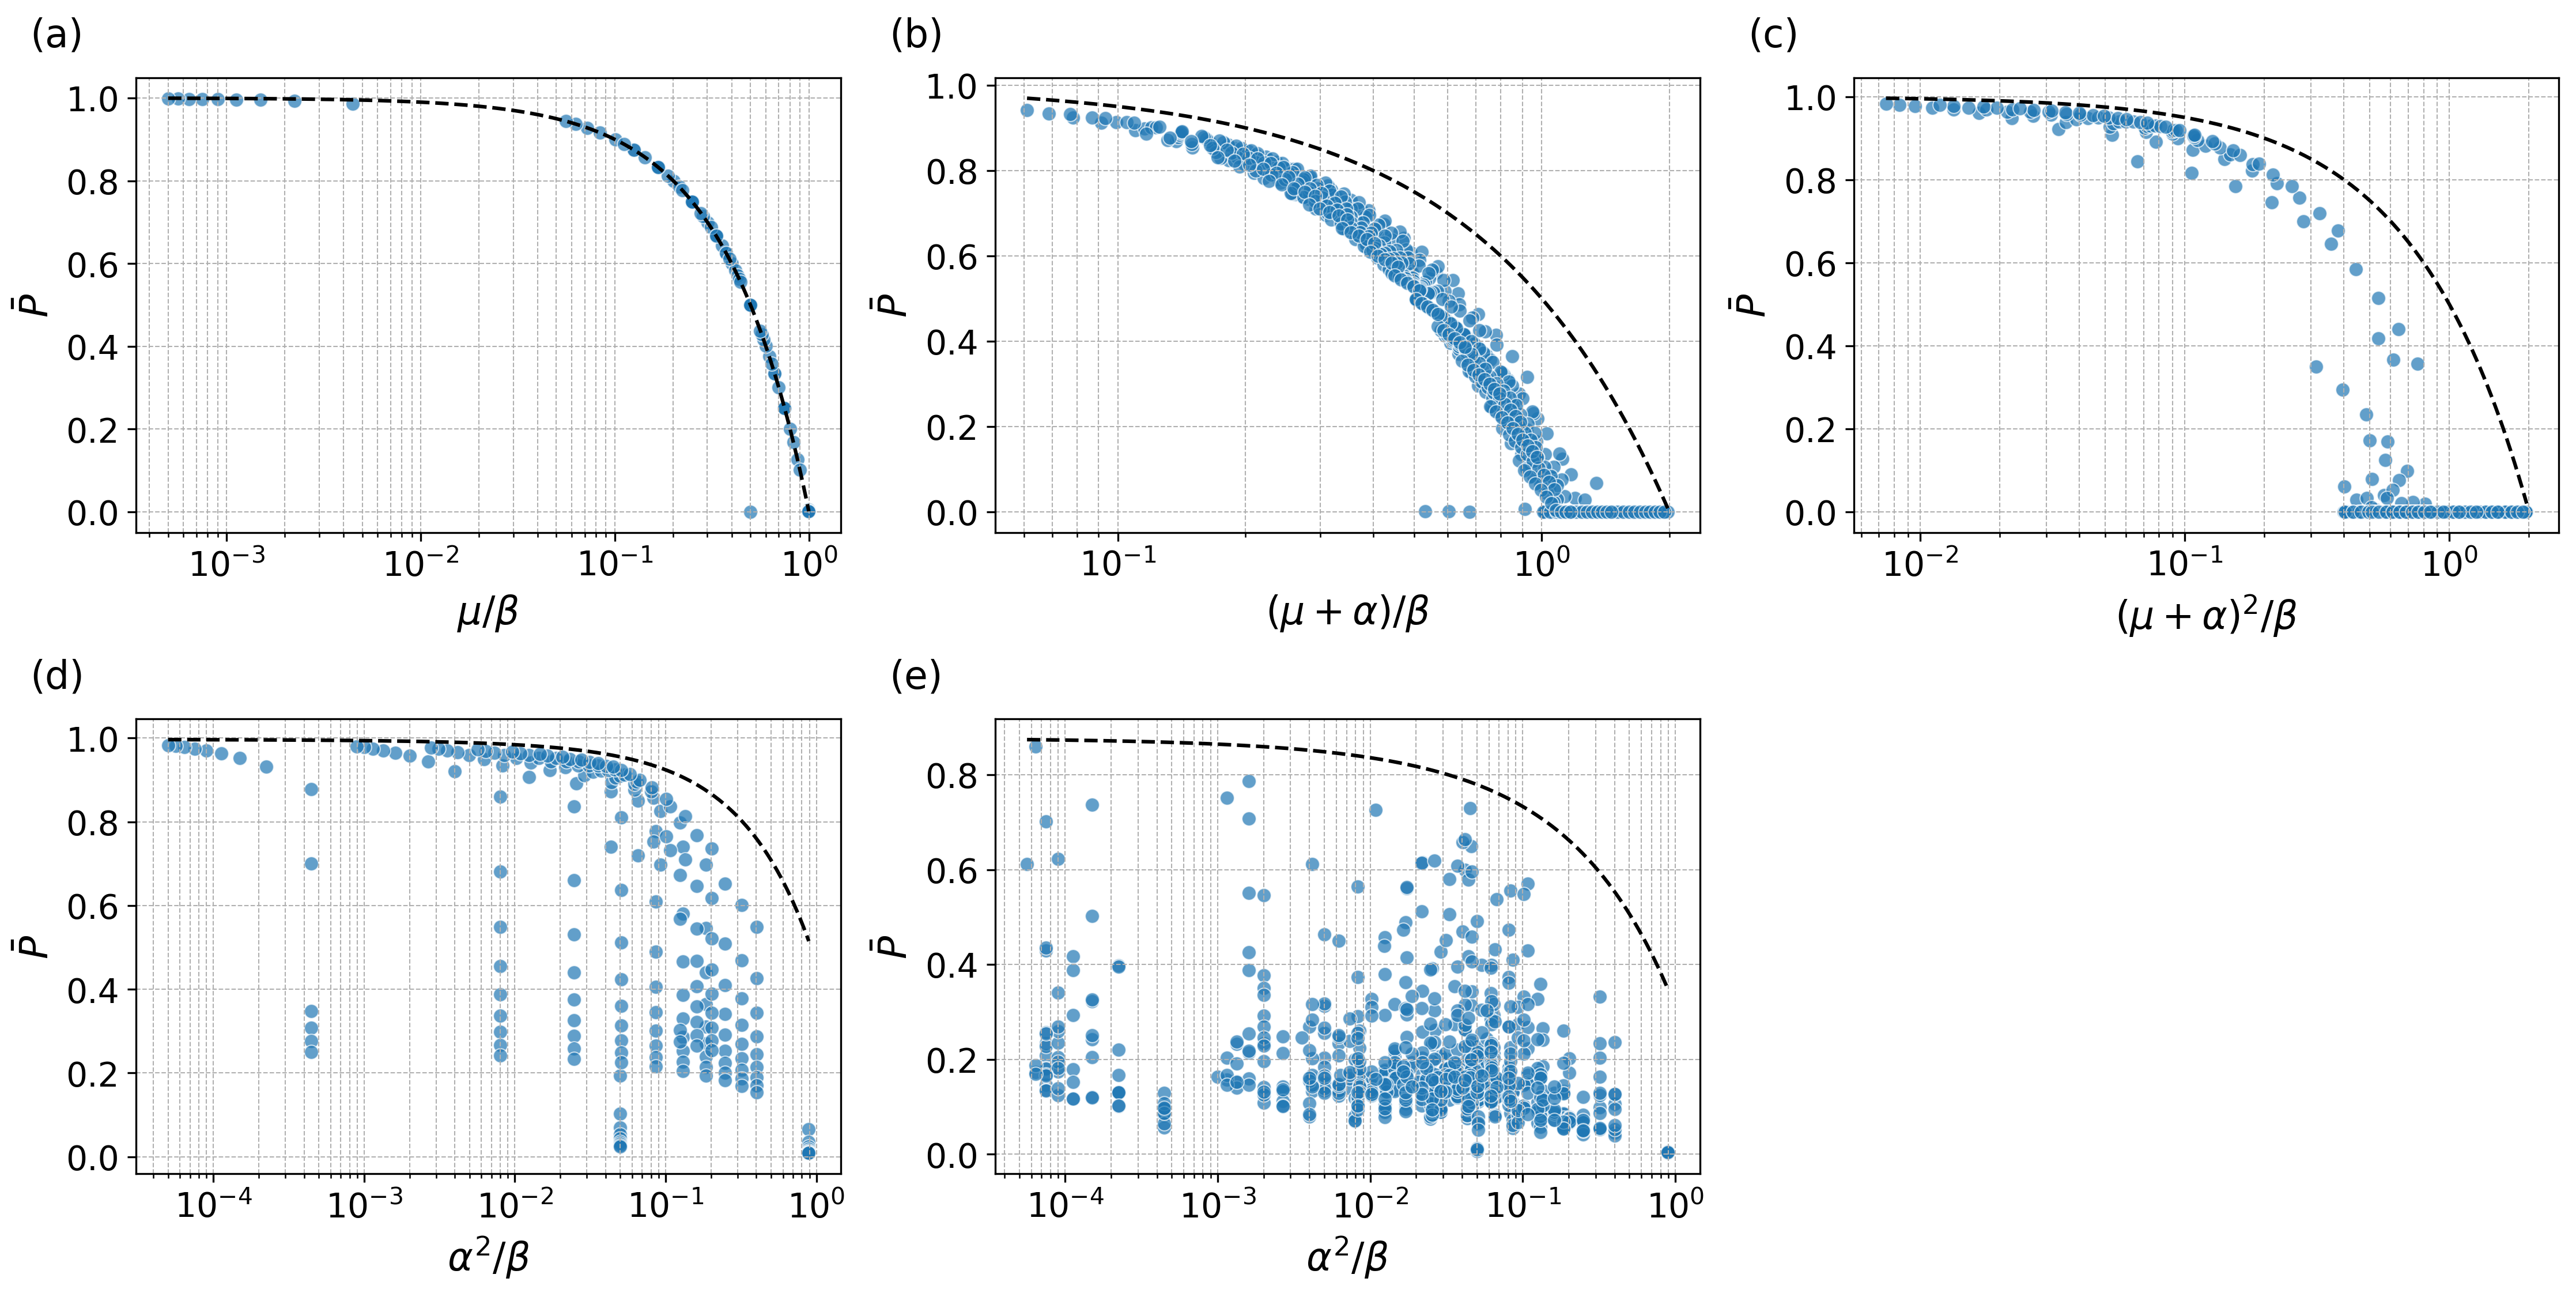

In [ ]:
# FIGURE 1: constraints on steady-state population density
# Filter data
csv_path = "grid_search_results_parallel_10.csv"
df = pd.read_csv(csv_path)
df_filtered = df[df["err_SSD_Linf"] < 1e-3].copy() # only keep converged simulations

# Compute ratios
df_filtered["mu_over_beta"] = df_filtered["mu0"] / df_filtered["b0"]
df_filtered["mu_plus_alpha_over_beta"] = (df_filtered["mu0"] + df_filtered["alpha"]) / df_filtered["b0"]
df_filtered["mu_plus_alpha_sq_over_beta"] = (df_filtered["mu0"] + df_filtered["alpha"])**2 / df_filtered["b0"]
df_filtered["alpha_sq_over_beta"] = df_filtered["alpha"]**2 / df_filtered["b0"]

# Labels 
ratio_plot_info = {
    "case1": r"$\mu / \beta$",
    "case2": r"$(\mu + \alpha)/\beta$",
    "case3": r"$(\mu + \alpha)^2 / \beta$",
    "case4": r"$\alpha^2 / \beta$",
    "case5": r"$\alpha^2 / \beta$"
}

# Set up plots 
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

# Remove the last subplot
axes[5].remove()

# Adjust layout to make room for removed subplot
plt.subplots_adjust(wspace=0.3, hspace=0.4)

for i, (key, label) in enumerate(ratio_plot_info.items()):
    ax = axes[i]
    
    case_num = int(key[-1])
    df_case = df_filtered[df_filtered["case"] == case_num].copy()
    
    # Keep only unique parameter combinations 
    param_cols = ["mu0", "b0", "alpha", "gamma", "delta"]
    available_cols = [col for col in param_cols if col in df_case.columns]
    df_case = df_case.drop_duplicates(subset=available_cols)

    # Select appropriate ratio for scatter plot
    if key == "case1":
        x = df_case["mu_over_beta"]
    elif key == "case2":
        x = df_case["mu_plus_alpha_over_beta"]
    elif key == "case3":
        x = df_case["mu_plus_alpha_sq_over_beta"]
    elif key in ["case4", "case5"]:
        x = df_case["alpha_sq_over_beta"]

    # Scatter plot of simulation results
    sns.scatterplot(
        data=df_case,
        x=x,
        y="P_bar",
        s=35,
        alpha=0.7,
        ax=ax,
        legend=False
    )
    ax.set_ylabel(r"$\bar{P}$")

    # Generate smooth theoretical curve
    x_min, x_max = x.min(), x.max()
    x_smooth = np.logspace(np.log10(x_min), np.log10(x_max), 1000)
    
    if key == "case1":
        y_smooth = 1 - x_smooth
    elif key == "case2":
        y_smooth = 1 - x_smooth / 2
    elif key == "case3":
        y_smooth = 1 - x_smooth / 2
    elif key == "case4":
        # Create envelope of theoretical curves to get proper upper bound
        x_min, x_max = x.min(), x.max()
        x_dense = np.logspace(np.log10(x_min), np.log10(x_max), 1000)
        
        # For each x value (and given the ratio of interest per case), calculate theoretical Pc across all \mu values
        # in the data. Since Pc depends on both \alpha, \beta, and \mu, we take the maximum to 
        # create an envelope that represents the upper bound across parameter space
        y_envelope = []
        
        for x_val in x_dense:
            max_pc = -np.inf
            
            # Try all parameter combinations from your data
            for _, row in df_case.iterrows():
                mu_val = row["mu0"]
                beta_val = row["b0"]
                
                # Calculate alpha needed for this x_val: alpha = sqrt(x_val * beta)
                alpha_val = np.sqrt(x_val * beta_val)
                
                disc = (alpha_val * mu_val + beta_val)**2 - mu_val**2 * (alpha_val**2 - 2 * beta_val)
                
                if disc > 0:
                    pc_val = (- (alpha_val * mu_val + beta_val) + np.sqrt(disc)) / mu_val**2
                    max_pc = max(max_pc, pc_val)
            
            y_envelope.append(max_pc if max_pc > -np.inf else np.nan)
        
        x_smooth = x_dense
        y_smooth = np.array(y_envelope)
        
    elif key == "case5":
        # Create envelope of theoretical curves to get proper upper bound
        x_min, x_max = x.min(), x.max()
        x_dense = np.logspace(np.log10(x_min), np.log10(x_max), 1000)
        
        # For each x value, find the maximum possible Pc across all parameter combinations
        y_envelope = []
        
        for x_val in x_dense:
            max_pc = -np.inf
            
            # Try all parameter combinations from your data
            for _, row in df_case.iterrows():
                gamma_val = row["gamma"]
                beta_val = row["b0"]
                
                # Calculate alpha needed for this x_val: alpha = sqrt(x_val * beta)
                alpha_val = np.sqrt(x_val * beta_val)
                
                disc = (alpha_val * gamma_val + beta_val)**2 - gamma_val**2 * (alpha_val**2 - 2 * beta_val)
                
                if disc > 0:
                    pc_val = (- (alpha_val * gamma_val + beta_val) + np.sqrt(disc)) / gamma_val**2
                    max_pc = max(max_pc, pc_val)
            
            y_envelope.append(max_pc if max_pc > -np.inf else np.nan)
        
        x_smooth = x_dense
        y_smooth = np.array(y_envelope)

    # Plot smooth theoretical curve
    valid_smooth = ~np.isnan(y_smooth)
    ax.plot(x_smooth[valid_smooth], y_smooth[valid_smooth], 'k--', lw=1.5)

    ax.set_xscale("log")
    ax.set_xlabel(label)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Panel label 
    ax.text(-0.15, 1.05, f"({chr(97 + i)})", transform=ax.transAxes, 
        fontsize=16, va='bottom', ha='left')

plt.tight_layout(rect=[0, 0, 1, 0.95])
# plt.savefig("Fig1.png", dpi=600, bbox_inches='tight')
plt.show()

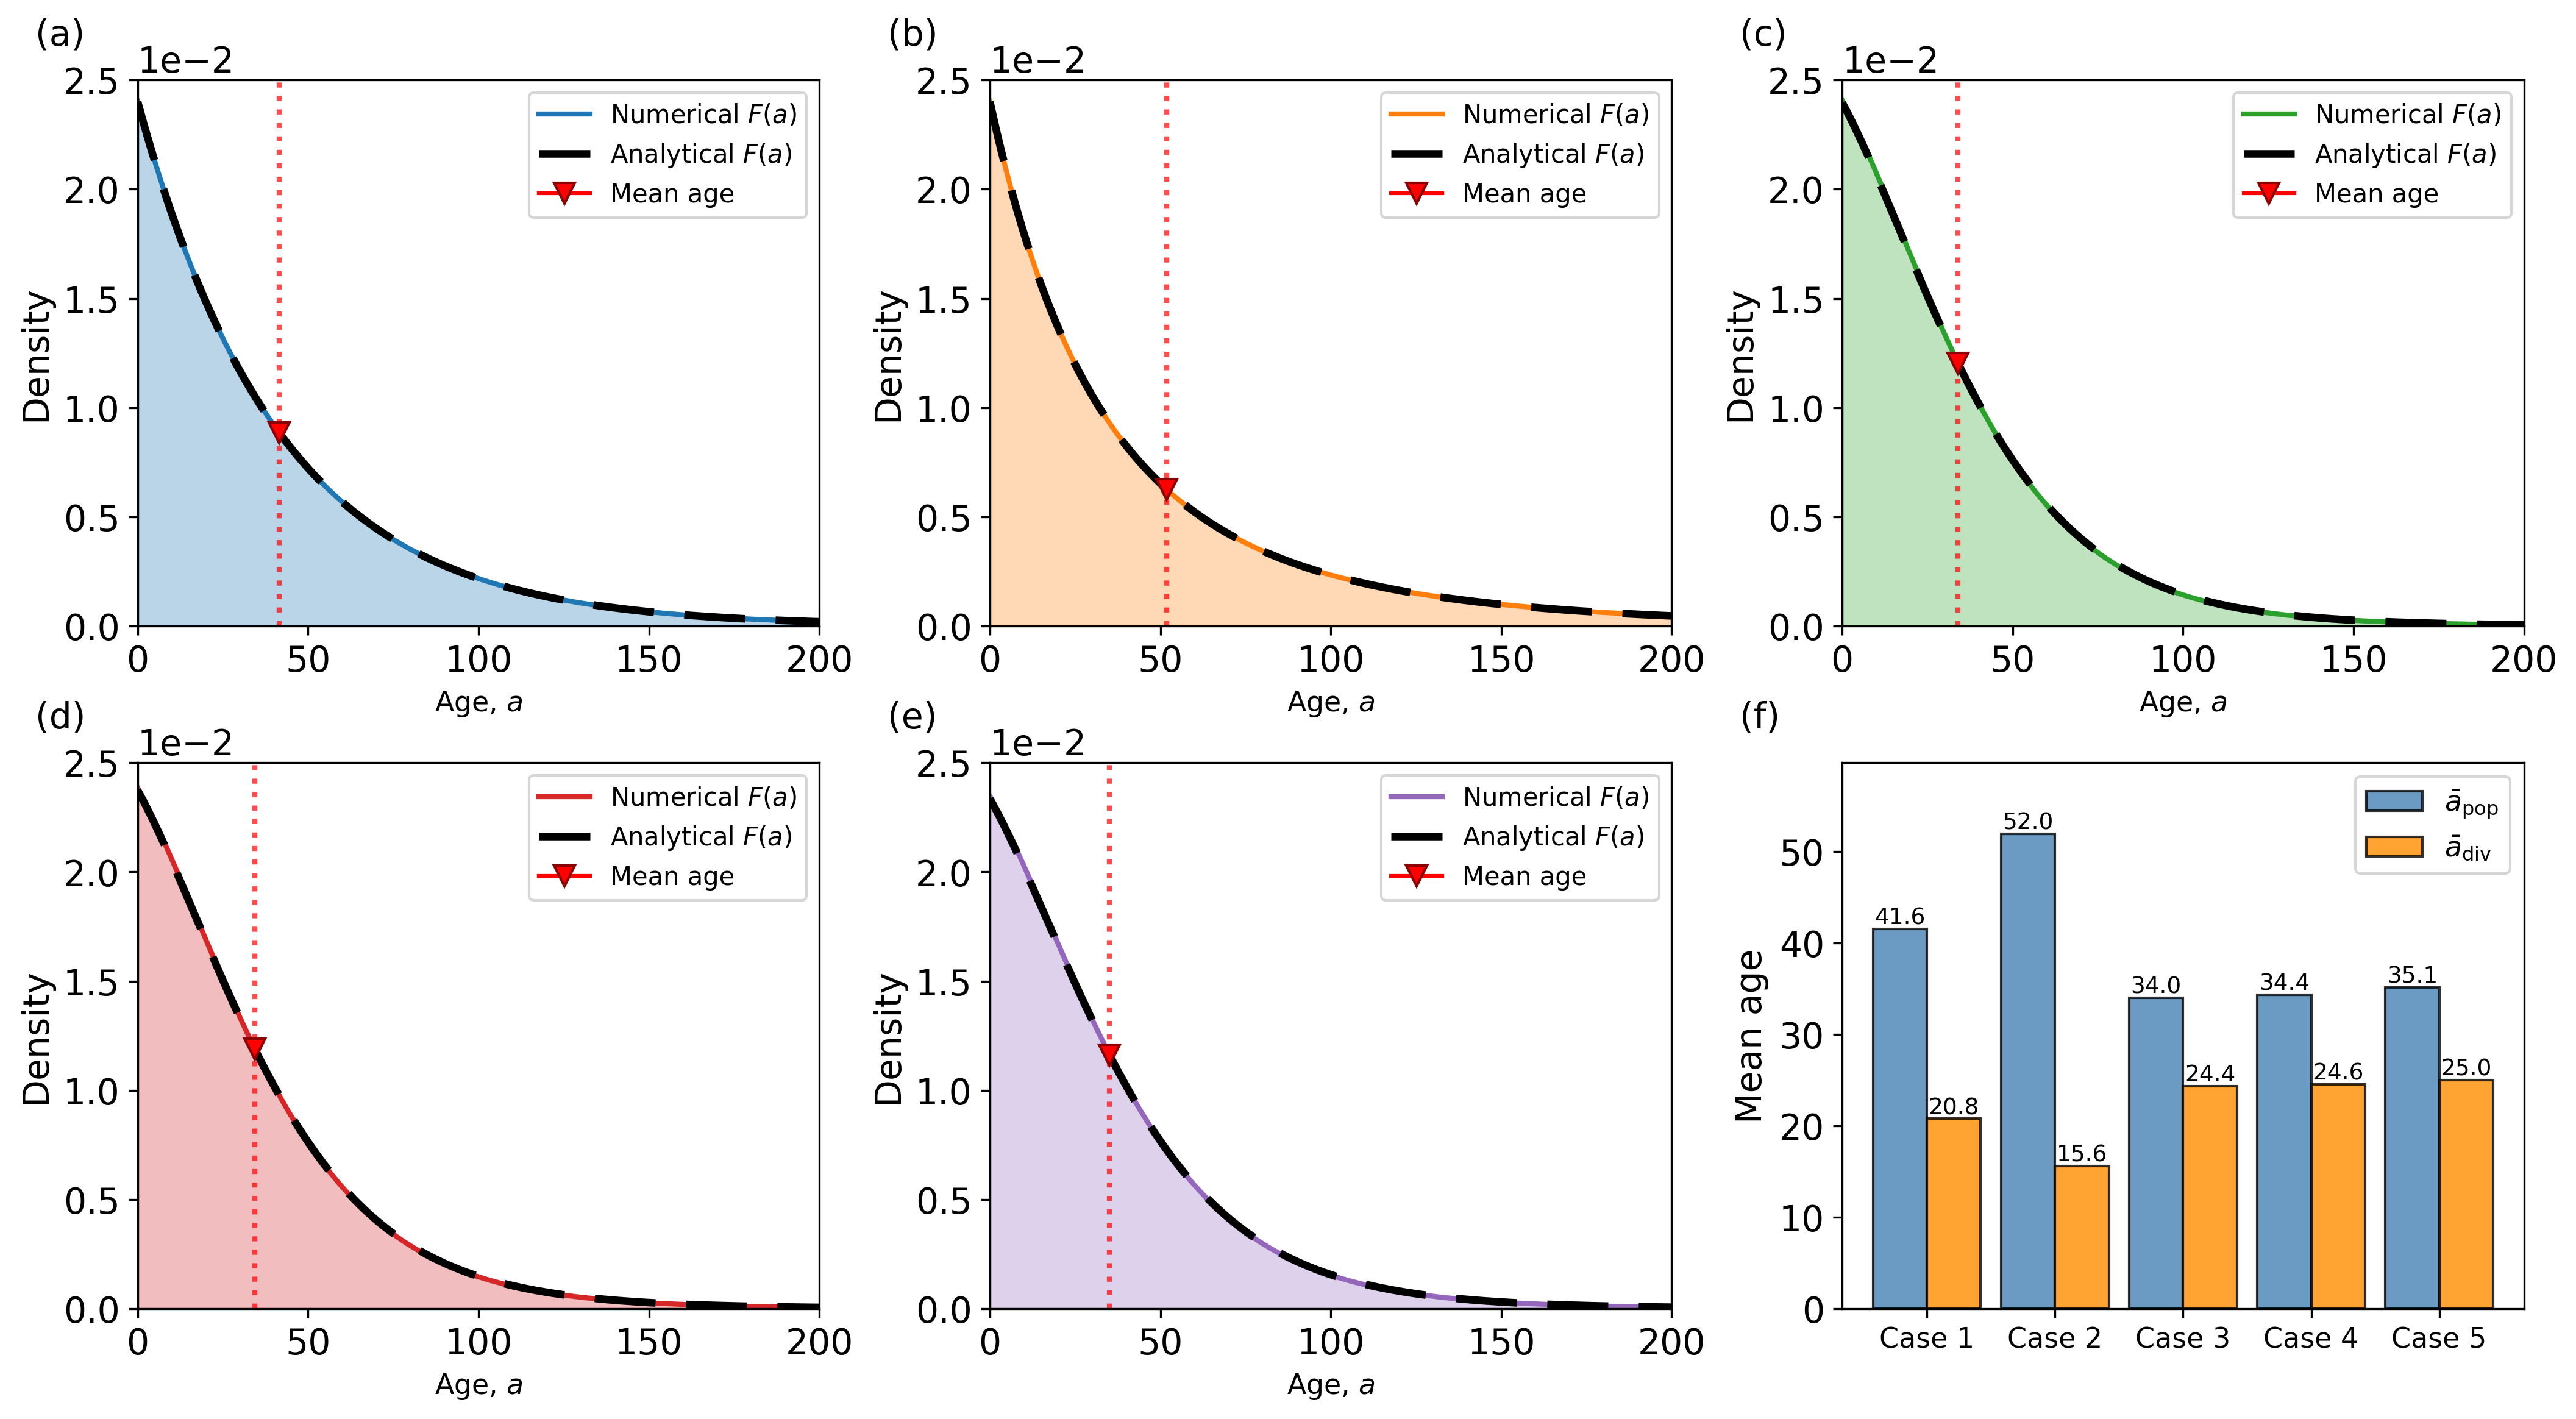

In [ ]:
def plot_ssd(model_data, make_steady_state_distributions, compute_mean_ages):
    """
    2x3 layout: Row 1-2 individual cases, last panel mean ages comparison
    """
    # Professional color palette
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    # Create figure with compact layout
    fig = plt.figure(figsize=(15, 8))
    gs = fig.add_gridspec(2, 3, hspace=0.25, wspace=0.25)
    
    case_labels = []
    mean_pop_ages = []
    mean_div_ages = []
    
    # Process each case (Cases 1-5)
    for idx, data in enumerate(model_data[:5]):
        # Determine subplot position
        if idx < 3:  # Row 1: panels 0, 1, 2
            ax = fig.add_subplot(gs[0, idx])
        else:  # Row 2: panels 0, 1 (idx 3, 4)
            ax = fig.add_subplot(gs[1, idx-3])
        
        a = data['a_final']
        u = data['u_final']
        P_bar = data['P_bar']
        D_bar = data['D_bar']
        case_num = data['case_num']
        params = data['params'].item() if isinstance(data['params'], np.ndarray) else data['params']
        colour = colours[idx]
        
        # Extend to age 200 if needed
        if a[-1] < 200:
            a_extended = np.linspace(0, 200, 1000)
            u_extended = np.interp(a_extended, a, u, right=0)
            a = a_extended
            u = u_extended
        
        # Compute F(a) with extended age array
        ssd_dict = make_steady_state_distributions(
            beta=params['b0'], alpha=params['alpha'], mu=params['mu0'],
            gamma=params['gamma'], P_bar=P_bar
        )
        F = ssd_dict[case_num](a)
        
        # Compute mean ages
        mean_div_age, mean_pop_age = compute_mean_ages(
            params['b0'], params['alpha'], params['gamma'], params['mu0'],
            [P_bar], a, case_num, return_values=True
        )
        
        # Store for later use
        mean_pop_ages.append(mean_pop_age)
        mean_div_ages.append(mean_div_age)
        case_labels.append(f"{case_num}")
        
        # Plot individual case with shading and markers
        # Normalise densities first
        u /= simpson(u, a)
        F /= simpson(F, a)
        ax.fill_between(a, 0, u, alpha=0.3, color=colour, label='_nolegend_')
        ax.plot(a, u, linewidth=2, color=colour)
        ax.plot(a, F, '--', linewidth=3, color='black', dashes=(8, 4))
        
        # Add mean age marker
        F_interp = np.interp(mean_pop_age, a, F)
        ax.axvline(mean_pop_age, color='red', linestyle=':', linewidth=2, alpha=0.7, label='_nolegend_')
        ax.plot(mean_pop_age, F_interp, marker='v', color='red', markersize=8, 
                markeredgecolor='darkred', markeredgewidth=1)
        
        # Formatting
        ax.set_xlim(0, 200)
        ax.set_ylim(0, 2.5e-2)
        ax.set_xlabel("Age, $a$", fontsize=11)
        ax.set_ylabel("Density", fontsize=14)
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        
        # Panel label 
        ax.text(-0.15, 1.05, f"({chr(97 + idx)})", transform=ax.transAxes, 
                fontsize=14, va='bottom', ha='left')
        
        # Legend on each plot
        ax.legend([r"Numerical $F(a)$", r"Analytical $F(a)$", "Mean age"], 
                 fontsize=10, loc='upper right')
    
    # Panel f: Mean ages comparison
    ax_means = fig.add_subplot(gs[1, 2])
    
    x = np.arange(len(case_labels))
    width = 0.42
    
    bars1 = ax_means.bar(x - width/2, mean_pop_ages, width, label=r'$\bar{a}_{\text{pop}}$', 
                        color='steelblue', alpha=0.8, edgecolor='black', linewidth=1)
    bars2 = ax_means.bar(x + width/2, mean_div_ages, width, label=r'$\bar{a}_{\text{div}}$', 
                        color='darkorange', alpha=0.8, edgecolor='black', linewidth=1)
    
    # Add padding
    ax_means.set_ylim(top=max(max(mean_pop_ages), max(mean_div_ages)) * 1.15)  # Add 15% padding

    # Add values on bars
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax_means.text(bar.get_x() + bar.get_width()/2., height,
                         f'{height:.1f}', ha='center', va='bottom', fontsize=9)
    
    ax_means.set_xticks(x)
    ax_means.set_xticklabels([f"Case {c}" for c in case_labels], fontsize=11)
    ax_means.set_ylabel("Mean age", fontsize=14)
    ax_means.legend(fontsize=11)
    ax_means.text(-0.15, 1.05, "(f)", transform=ax_means.transAxes, 
                  fontsize=14, va='bottom', ha='left')
    
    plt.subplots_adjust(left=0.08, right=0.95, top=0.92, bottom=0.08)
    plt.show()
    return fig

fig = plot_ssd(model_data, make_steady_state_distributions, compute_mean_ages)
# fig.savefig("Fig2.png", dpi=600, bbox_inches='tight')

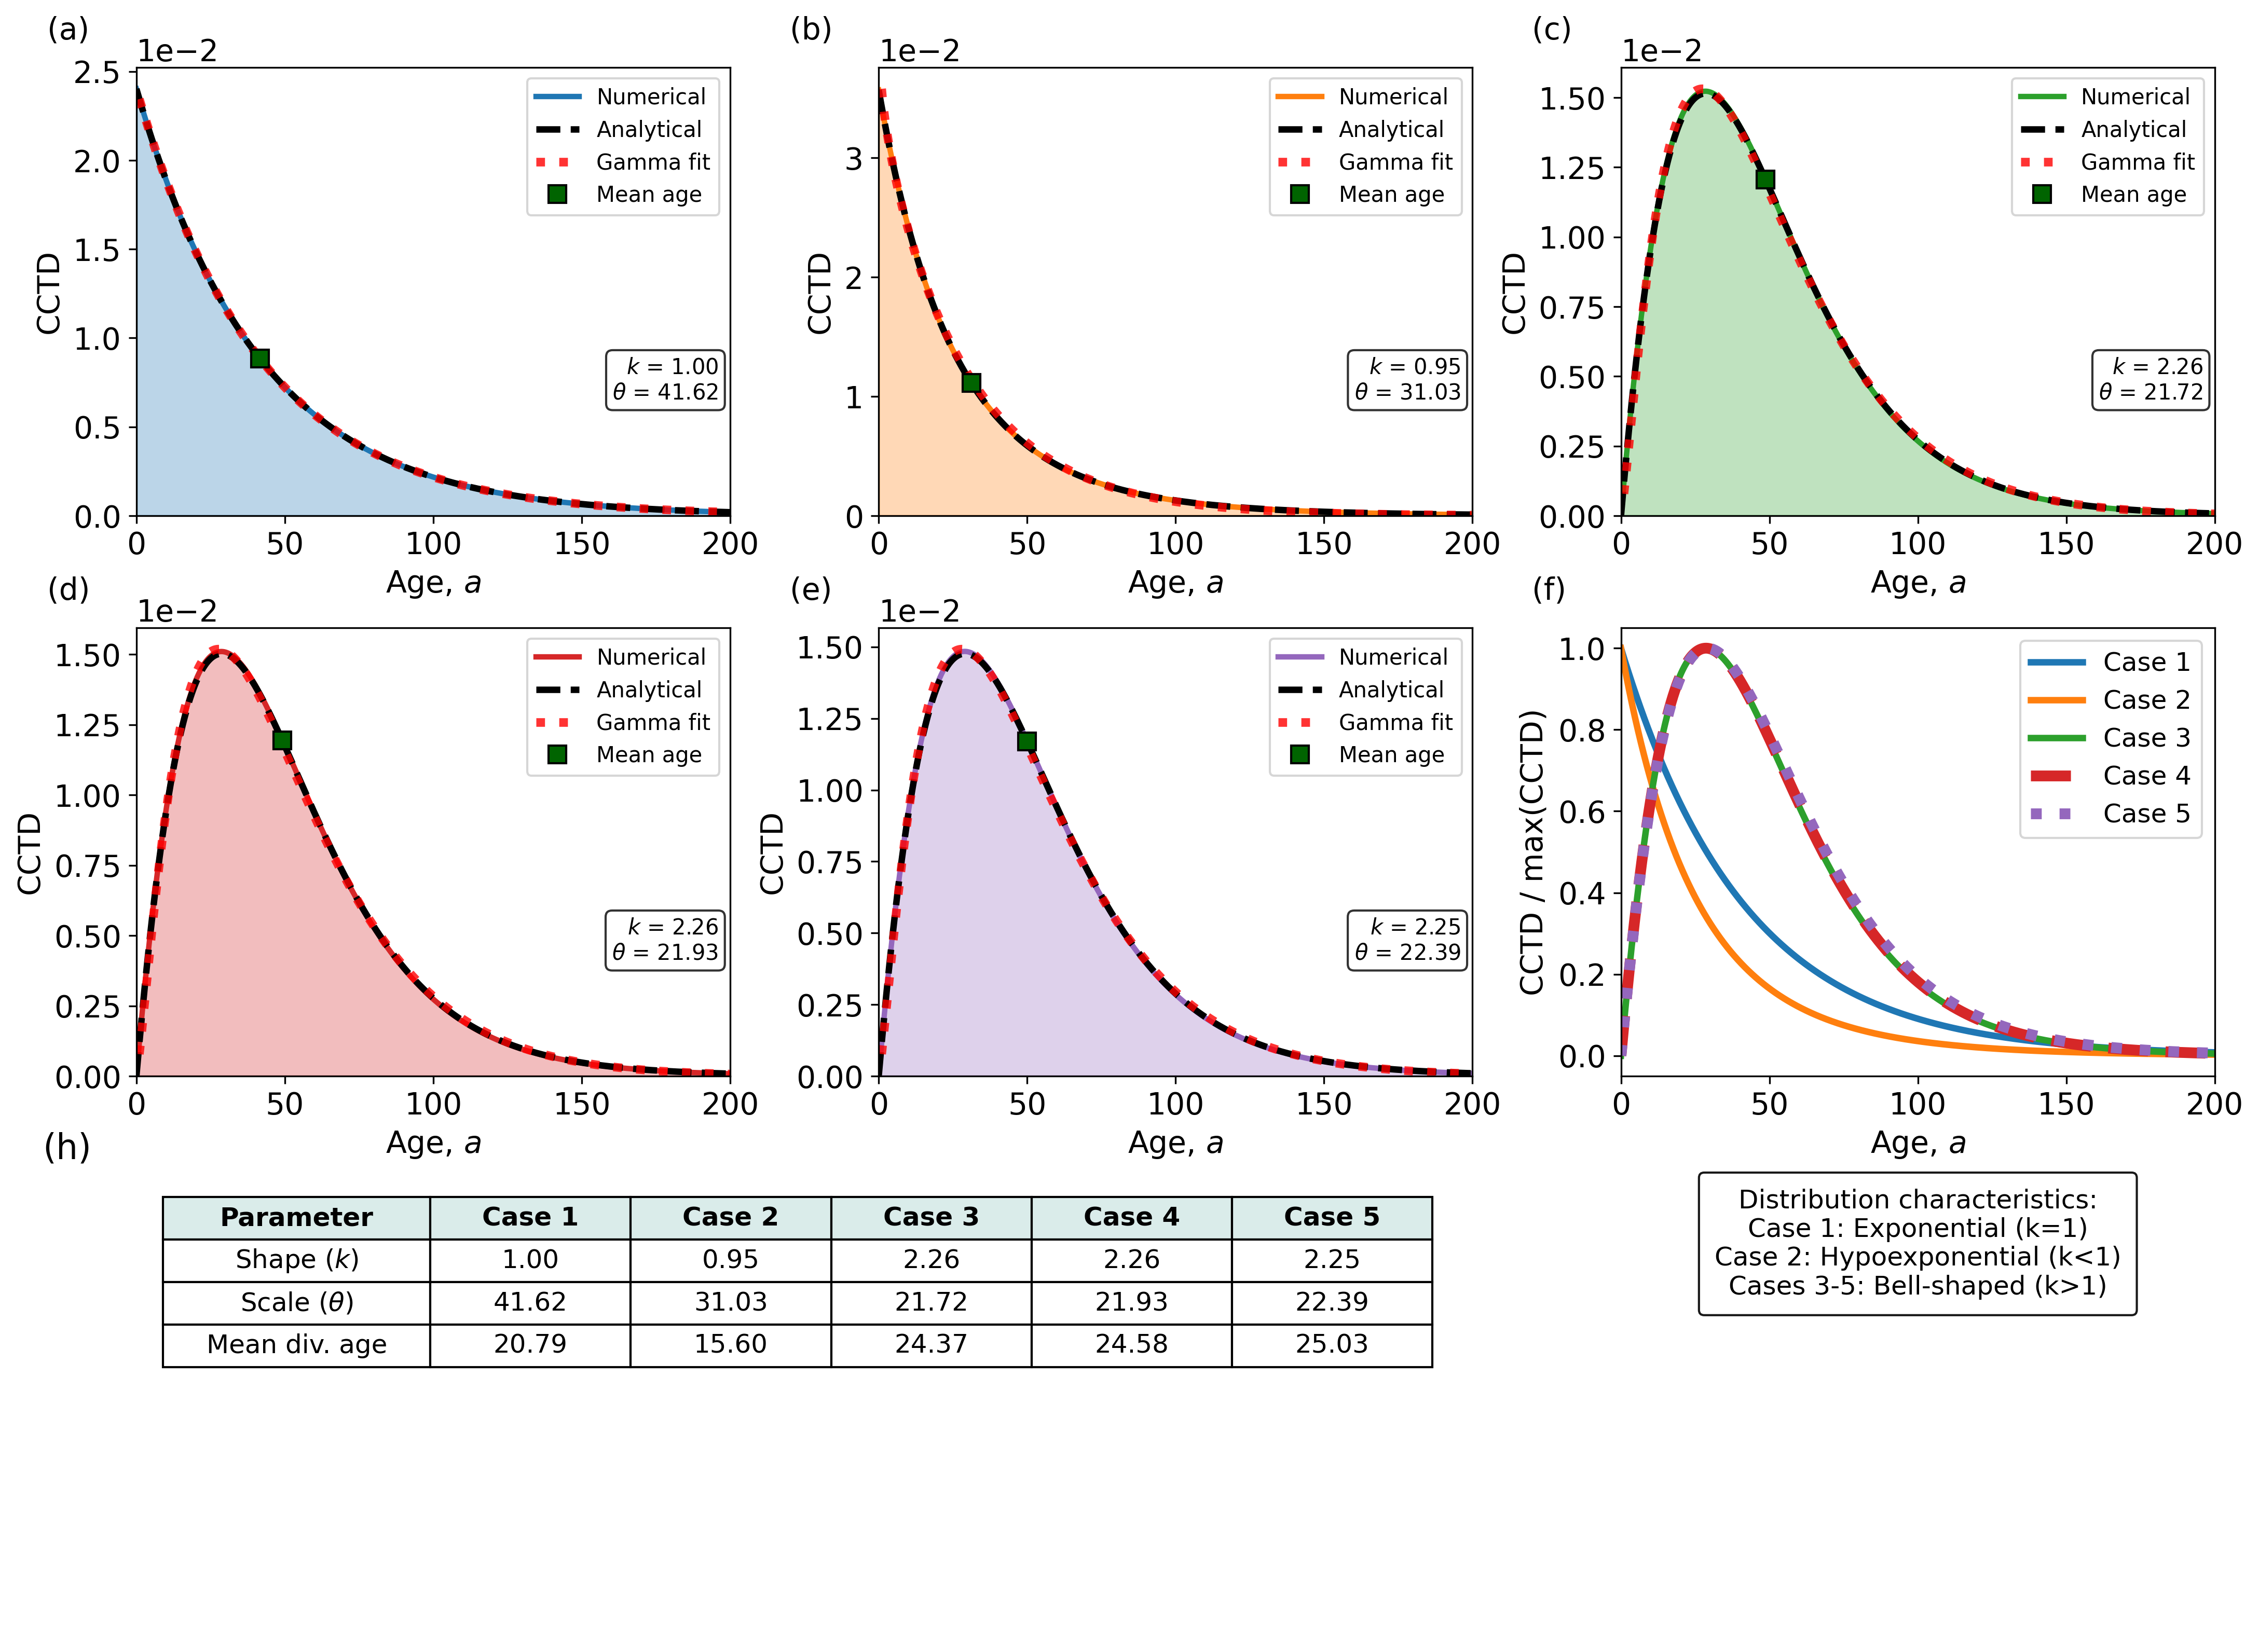

In [ ]:
def gamma_pdf(a, k, theta):
    """Gamma PDF with shape k and scale theta"""
    return gamma.pdf(a, a=k, scale=theta)

def fit_gamma_to_cctd(ages, cctd_values, amin=1.0):
    """Fit gamma distribution to CCTD data, skipping low-age noise"""
    mask = ages >= amin
    ages = ages[mask]
    cctd_values = cctd_values[mask]

    mean_age = np.trapezoid(ages * cctd_values, ages)
    var_age = np.trapezoid(ages**2 * cctd_values, ages) - mean_age**2
    k_init = mean_age**2 / var_age
    theta_init = var_age / mean_age

    try:
        popt, _ = curve_fit(
            gamma_pdf, ages, cctd_values,
            p0=[k_init, theta_init],
            bounds=([1e-2, 1e-3], [10, 1000])
        )
        return popt, True
    except:
        return [k_init, theta_init], False

def compute_cctd_numerical(data):
    """Compute numerical CCTD from simulation data"""
    a = data['a_final']
    u = data['u_final']
    P_bar = data['P_bar']
    case_num = data['case_num']
    params = data['params'].item() if isinstance(data['params'], np.ndarray) else data['params']
    
    numerical_cctd = division_rate(params['b0'], params['alpha'], a, P_bar, case_num) * u
    numerical_cctd /= simpson(numerical_cctd, a)
    
    return numerical_cctd

def compute_cctd_analytical(case_num, params, P_bar, ages):
    """Compute analytical CCTD using existing functions"""
    from NoDiffusionStatistics import make_cctd_functions
    
    cctd_dict = make_cctd_functions(
        beta=params['b0'], alpha=params['alpha'], mu=params['mu0'],
        gamma=params['gamma'], P_bar=P_bar
    )
    cctd_fn = cctd_dict[case_num]
    analytical_cctd = cctd_fn(ages)
    analytical_cctd /= simpson(analytical_cctd, ages)
    
    return analytical_cctd

def plot_cctd(model_data, compute_cctd_analytical, compute_mean_ages, amin=1.0):
    colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    fig = plt.figure(figsize=(15, 12)) 
    gs = fig.add_gridspec(3, 3, hspace=0.25, wspace=0.25)

    l2_errors = []
    r2_scores = []
    mean_div_times = []
    gamma_params = []
    all_cctd_data = []
    case_labels = []

    # Metrics for each case
    bio_stats = []
    for idx, data in enumerate(model_data[:5]):
        a = data['a_final']
        case_num = data['case_num']
        params = data['params'].item() if isinstance(data['params'], np.ndarray) else data['params']
        colour = colours[idx]
        
        # Use analytical CCTD (normalised already; see function above)
        cctd_analytical = compute_cctd_analytical(case_num, params, data['P_bar'], a)
        
        # Early dividers (% dividing before age \approx 1/alpha)
        mask_early = a <= 1 / params['alpha']
        early_div = np.trapezoid(cctd_analytical[mask_early], a[mask_early]) * 100

        # Late dividers (% dividing after age approx (1/alpha)*2)
        mask_late = a >= (1 / params['alpha']) * 2
        late_div = np.trapezoid(cctd_analytical[mask_late], a[mask_late]) * 100

        
        bio_stats.append({
            'case': case_num,
            'early': early_div,
            'late': late_div
        })

    # Row 1: Individual CCTD panels (Cases 1-3)
    panel_positions = [(0,0), (0,1), (0,2), (1,0), (1,1)]  # cases 1–5 
    for idx in range(5):
        row, col = panel_positions[idx]
        ax = fig.add_subplot(gs[row, col])
        data = model_data[idx]
        a = data['a_final']
        u = data['u_final']
        P_bar = data['P_bar']
        case_num = data['case_num']
        params = data['params'].item() if isinstance(data['params'], np.ndarray) else data['params']
        colour = colours[idx]

        # Numerical CCTD
        numerical_cctd = division_rate(params['b0'], params['alpha'], a, P_bar, case_num) * u
        numerical_cctd /= simpson(numerical_cctd, a)

        # Analytical CCTD
        cctd_analytical = compute_cctd_analytical(case_num, params, P_bar, a)

        # Gamma fit 
        gamma_fit_params, fit_success = fit_gamma_to_cctd(a, numerical_cctd, amin=amin)
        k_fit, theta_fit = gamma_fit_params
        mask_original = a >= amin
        cctd_gamma_original = gamma_pdf(a[mask_original], k_fit, theta_fit)

        # Extend to age 200 if needed
        if a[-1] < 200:
            a_extended = np.linspace(0, 200, 1000)
            numerical_cctd = np.interp(a_extended, a, numerical_cctd, right=0)
            cctd_analytical = np.interp(a_extended, a, cctd_analytical, right=0)
            mask_extended = a_extended >= amin
            cctd_gamma = gamma_pdf(a_extended, k_fit, theta_fit)
            a = a_extended
        else:
            mask_extended = mask_original
            cctd_gamma = np.zeros_like(a)
            cctd_gamma[mask_original] = cctd_gamma_original

        # Compute mean age for marker
        mean_div_age = np.trapezoid(a * numerical_cctd, a)
        
        # Plot with shading
        ax.fill_between(a, 0, numerical_cctd, alpha=0.3, color=colour, label='_nolegend_')
        ax.plot(a, numerical_cctd, linewidth=2.5, color=colour, label='Numerical')
        ax.plot(a, cctd_analytical, '--', linewidth=3, color='black', label='Analytical')
        ax.set_xlabel("Age, $a$", fontsize=14)
        ax.plot(a[mask_extended], cctd_gamma[mask_extended], ':', linewidth=4, 
            color='red', alpha=0.8, label='Gamma fit')
                
        # Mark mean age with square
        cctd_interp = np.interp(mean_div_age, a, numerical_cctd)
        ax.plot(mean_div_age, cctd_interp, marker='s', color='darkgreen', 
            markersize=8, markeredgecolor='black', markeredgewidth=1, 
            linestyle='None', label='Mean age')  # Add linestyle='None'
        # ax.axvline(mean_div_age, color='darkgreen', linestyle=':', linewidth=2, alpha=0.7)
                
        # Add gamma parameters below the plot
        ax.text(0.98, 0.25, f'$k$ = {k_fit:.2f}\n$\\theta$ = {theta_fit:.2f}', 
                transform=ax.transAxes, fontsize=10, ha='right', va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

        # Legend
        ax.legend(fontsize=10, loc='upper right') 
        ax.set_xlim(0, 200)
        ax.set_ylim(bottom=0)
        # ax.set_ylim(0, 3.6e-2) 
        ax.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
        ax.text(-0.15, 1.05, f"({chr(97 + idx)})", transform=ax.transAxes, 
                fontsize=14, va='bottom', ha='left')

        
        ax.set_ylabel("CCTD", fontsize=14)

        # Store metrics
        l2_error = np.sqrt(simpson((numerical_cctd - cctd_analytical)**2, a))
        r2_score_val = r2_score(numerical_cctd[mask_extended], cctd_gamma[mask_extended])
        mean_div_age_precise, mean_pop_age = compute_mean_ages(
            params['b0'], params['alpha'], params['gamma'], params['mu0'],
            [P_bar], a, case_num, return_values=True
        )
        
        l2_errors.append(l2_error)
        r2_scores.append(r2_score_val)
        mean_div_times.append(mean_div_age_precise)
        gamma_params.append([k_fit, theta_fit])
        case_labels.append(f"{case_num}")

        # Store for overlay
        norm_cctd = numerical_cctd / np.max(numerical_cctd)
        all_cctd_data.append((a, norm_cctd, colour, case_num))

    # Row 2: Individual CCTD panels (Cases 4-5) + normalized overlay 
    ax_overlay = fig.add_subplot(gs[1, 2])

    # Main overlay plot
    for idx, (a_ext, cctd_norm, colour, case_num) in enumerate(all_cctd_data):
        linewidth = 5 if idx == 3 else 5 if idx == 4 else 3 # case 4 and 5 emphasized for better visibility
        linestyle = '--' if idx == 3 else ':' if idx == 4 else '-' 
        ax_overlay.plot(a_ext, cctd_norm, linewidth=linewidth, linestyle=linestyle,
                            color=colour, label=f"Case {case_num}")

    ax_overlay.set_xlim(0, 200)
    ax_overlay.set_xlabel("Age, $a$", fontsize=14)
    ax_overlay.set_ylabel("CCTD / max(CCTD)", fontsize=14)

    # Add biological interpretation text box
    stats_text = f"Distribution characteristics:\n"
    stats_text += f"Case 1: Exponential (k=1)\n"
    stats_text += f"Case 2: Hypoexponential (k<1)\n" 
    stats_text += f"Cases 3-5: Bell-shaped (k>1)"

    # Legend in top-right corner
    ax_overlay.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1))
    ax_overlay.text(-0.15, 1.05, "(f)", transform=ax_overlay.transAxes,
                        fontsize=14, va='bottom', ha='left')
    
    # Row 3: Parameter table 
    ax_table = fig.add_subplot(gs[2, 0:2])
    ax_table.axis('off')
    ax_table.set_anchor('NW')  # anchor to top-left
    
    headers = ['Parameter'] + [f'Case {c}' for c in case_labels]
    shape_row = ['Shape ($k$)'] + [f'{p[0]:.2f}' for p in gamma_params]
    scale_row = ['Scale ($\\theta$)'] + [f'{p[1]:.2f}' for p in gamma_params]
    mean_row = ['Mean div. age'] + [f'{m:.2f}' for m in mean_div_times]
    # early_row = ['Early div. (%)'] + [f'{stat["early"]:.1f}' for stat in bio_stats]
    
    table_data = [shape_row, scale_row, mean_row]

    table = ax_table.table(
        cellText=table_data,
        colLabels=headers,
        cellLoc='center',
        loc='upper left',      # was 'center'
        # bbox=[0, 0, 0.7, 1],   #
        colWidths=[0.2] + [0.15]*5
    )

    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)  # I increased height to span subfigure height

    # Style header
    for i in range(len(headers)):
        table[(0, i)].set_facecolor("#DAECEA")
        table[(0, i)].set_text_props(weight='bold')
    
    ax_table.text(-0.07, 1.05, "(h)", transform=ax_table.transAxes, 
                  fontsize=16, va='bottom', ha='left')

    # --- Row 3, Column 3 (rightmost cell) ---
    ax_note = fig.add_subplot(gs[2, 2])
    ax_note.axis('off')
    ax_note.set_anchor('N')  # pin content to the top edge of this panel

    ax_note.text(
    0.5, 1.0, stats_text,
    transform=ax_note.transAxes,
    fontsize=12,
    ha='center', va='top',
    linespacing=1.2,  # more space between lines
    bbox=dict(boxstyle='round,pad=0.6,rounding_size=0.2',
              facecolor='white', alpha=0.9)
    )

    plt.subplots_adjust(left=0.06, right=0.95, top=0.92, bottom=0.08)
    plt.show()
    return fig

fig = plot_cctd(model_data, compute_cctd_analytical, compute_mean_ages)
# fig.savefig("Fig3.png", dpi=600, bbox_inches='tight')

In [9]:
# Load each dataset as a DataFrame
df1 = pd.read_csv('DMSO_data.csv')
df2 = pd.read_csv('erlot_data.csv')
df3 = pd.read_csv('CHX_data.csv')
df3.rename(columns={'Lifetime (h)': 'Lifetimeh'}, inplace=True)

# Extract the 'Lifetimeh' column (drop NaNs)
data1 = df1['Lifetimeh'].dropna().values
data2 = df2['Lifetimeh'].dropna().values
data3 = df3['Lifetimeh'].dropna().values

# Prepare data
data_list = [data1, data2, data3]
labels = ['DMSO', 'Erlotinib', 'CHX']

# Diagnostic
for i, data in enumerate(data_list):
    print(f"\n=== Dataset {labels[i]} ===")
    print(f"N observations: {len(data)}")
    print(f"Range: {np.min(data):.1f} - {np.max(data):.1f} hours")
    print(f"Mean ± std: {np.mean(data):.1f} ± {np.std(data):.1f} hours")
    print(f"Median: {np.median(data):.1f} hours")
    
    # Check for reasonable cell cycle times
    if np.mean(data) < 10 or np.mean(data) > 50:
        print(" Unusual mean cell cycle time")


=== Dataset DMSO ===
N observations: 383
Range: 9.7 - 65.1 hours
Mean ± std: 14.4 ± 5.4 hours
Median: 13.3 hours

=== Dataset Erlotinib ===
N observations: 460
Range: 10.6 - 67.7 hours
Mean ± std: 22.5 ± 13.2 hours
Median: 16.4 hours

=== Dataset CHX ===
N observations: 288
Range: 13.7 - 54.9 hours
Mean ± std: 23.1 ± 6.1 hours
Median: 21.5 hours


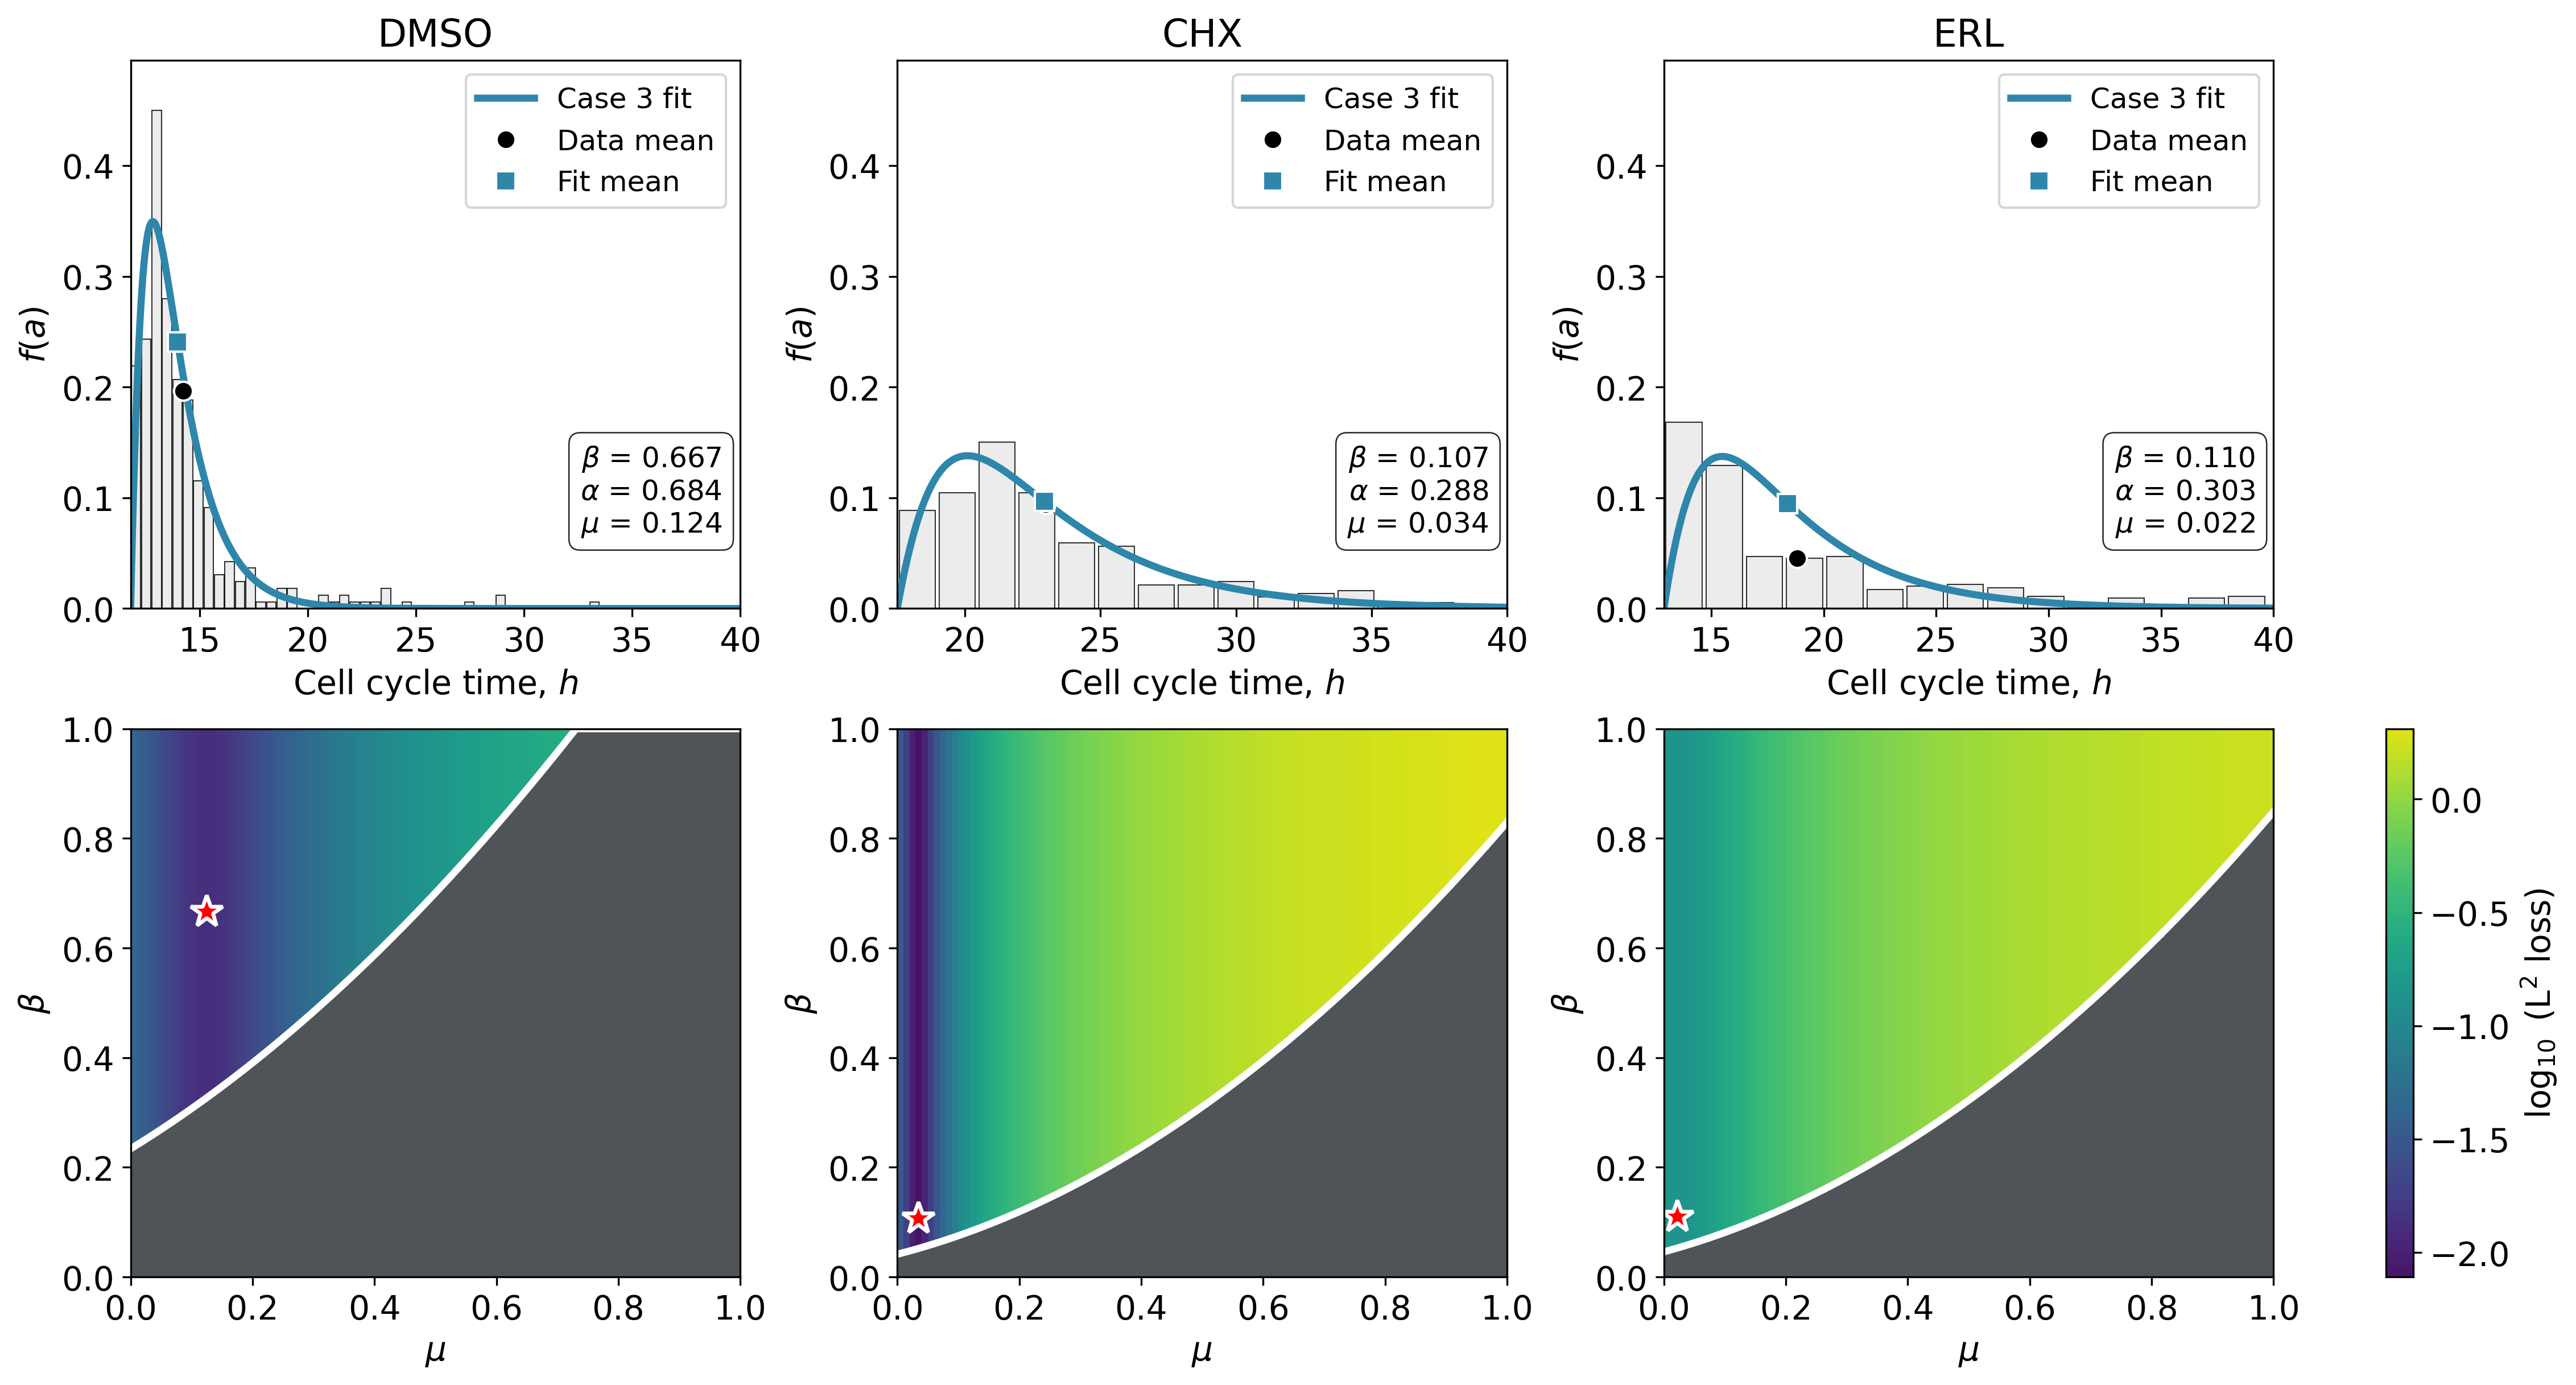

In [ ]:
"""
Case 3 CCTD fits + loss landscapes 
"""

# settings
MAX_H = 40.0
INFEAS_COLOUR = "#4E5458FF"    # light cool grey

# colormap setup
from matplotlib.colors import LinearSegmentedColormap

def make_cmap(name='YlGnBu', lo=0.05, hi=0.95):
    base = plt.get_cmap(name)
    colors = base(np.linspace(lo, hi, 256))
    cmap = LinearSegmentedColormap.from_list(f'{name}_trunc', colors)
    cmap.set_bad(INFEAS_COLOUR, 1.0)    # masked (infeasible) matches background
    return cmap

CMAP = make_cmap('viridis')   # others are: 'YlGnBu', 'cividis', 'viridis'


plt.rcParams.update({
    "figure.constrained_layout.use": True,
    "axes.grid": False,                       # no grid anywhere for this one
    "axes.titlesize": 16, "axes.labelsize": 14,
    "xtick.labelsize": 14, "ytick.labelsize": 14,
    "font.size": 14, "lines.linewidth": 2.0,
})

COL = {"data": "#E8E8E8", "case3": "#2E86AB"}
LABEL_MAP = {"CHX": "CHX", "DMSO": "DMSO", "ERL": "ERL", "ERLOTINIB": "ERL"}
ORDER = ["DMSO", "CHX", "ERL"]

def legend_name(label: str) -> str:
    u = label.upper()
    for k, v in LABEL_MAP.items():
        if k in u: return v
    return label

# Helper functions
def normalise_pdf(y, x):
    area = np.trapezoid(y, x)
    return y/area if (area > 0 and np.isfinite(area)) else np.zeros_like(y)

def histogram_density(data, bins="fd"):
    edges = np.histogram_bin_edges(data, bins=bins)
    f, _ = np.histogram(data, bins=edges, density=True)
    centres = 0.5 * (edges[:-1] + edges[1:])
    return f, edges, centres

def ecdf_on_grid(data, grid):
    d = np.sort(data); n = d.size
    if n == 0: return np.zeros_like(grid)
    ranks = np.searchsorted(d, grid, side="right")
    return ranks / n

def survival_on_points(data, points):
    grid = np.unique(np.concatenate([points, [points.min(), points.max()]]))
    cdf = ecdf_on_grid(data, grid)
    cdf_pts = np.interp(points, grid, cdf, left=0.0, right=1.0)
    return 1.0 - cdf_pts

# ---------------------- Case 3 model (fixed a0 from data) --------------------------------
def case3_cctd_fixed_a0(a, beta, alpha, mu, a0):
    """Predicted CCTD for Case 3 with fixed a0; returns a normalised density on a."""
    a = np.asarray(a, float)
    f = np.zeros_like(a)
    mask = a >= a0
    if not np.any(mask) or beta <= 0 or alpha <= 0 or mu < 0: return f
    Pbar = 1.0 - ((mu + alpha)**2) / (2.0 * beta)
    if not (0.0 < Pbar < 1.0): return f

    a_eff = a[mask] - a0
    birth_kernel = beta * a_eff * np.exp(-alpha * a_eff) * (1.0 - Pbar)
    beta_int = (beta * (1.0 - Pbar) / alpha**2) * (1.0 - np.exp(-alpha*a_eff)*(1.0 + alpha*a_eff))
    exponent = -mu * a_eff - beta_int
    f_val = birth_kernel * np.exp(exponent)
    f[mask] = np.where(np.isfinite(f_val), f_val, 0.0)
    return normalise_pdf(f, a)

# --------------------------- Fitting core --------------------------------------
def prepare_empirics(raw_times, a0_percentile):
    a0 = float(np.percentile(raw_times, a0_percentile))
    data = raw_times[(raw_times >= a0) & (raw_times <= MAX_H)]
    if data.size < 5: raise ValueError("Insufficient data after truncation.")
    a_eval = np.linspace(a0, MAX_H, 600)
    dx = a_eval[1] - a_eval[0]
    cdf_emp = ecdf_on_grid(data, a_eval)
    a_q80, a_q90 = np.percentile(data, [80.0, 90.0])
    anchor_points = np.array([a_q80, a_q90, MAX_H], float)
    S_emp = survival_on_points(data, anchor_points)
    return a0, data, a_eval, dx, cdf_emp, anchor_points, S_emp

def alpha_grid_from_data(data, a0, n_alpha=51):
    q10, q50 = np.percentile(data, [10.0, 50.0])
    t10, t50 = max(q10 - a0, 1e-3), max(q50 - a0, 1e-3)
    lo, hi = 1.0/max(t50,1e-3), 1.0/max(t10,1e-3)
    if hi < lo: lo, hi = hi, lo
    if not np.isfinite(lo) or not np.isfinite(hi) or lo <= 0: lo, hi = 1e-2, 1.0
    if np.isclose(lo, hi, rtol=1e-3, atol=1e-6): lo *= 0.8; hi *= 1.2
    return np.linspace(lo, hi, n_alpha)

def objective_components(beta, mu, alpha, a0, a_eval, dx, cdf_emp, anchor_points, S_emp, lam):
    f_model = case3_cctd_fixed_a0(a_eval, beta, alpha, mu, a0)
    cdf_mod = np.cumsum(f_model) * dx
    loss_cdf = np.sum((cdf_mod - cdf_emp)**2) * dx
    S_mod = 1.0 - np.interp(anchor_points, a_eval, cdf_mod, left=0.0, right=1.0)
    loss_tail = np.mean((S_mod - S_emp)**2)
    return loss_cdf + lam * loss_tail   # loss_no_penalty

def fit_case3_profile_alpha(raw_times, a0_percentile=10.0, n_alpha=21,
                            penalty_scale=1e6, lambda_anchor=0.5):
    """Profile alpha; for each alpha fit (beta, mu) by minimising loss_fit = loss_no_penalty + penalty."""
    a0, data, a_eval, dx, cdf_emp, anchor_points, S_emp = prepare_empirics(raw_times, a0_percentile)
    alphas = alpha_grid_from_data(data, a0, n_alpha=n_alpha)
    beta_bounds, mu_bounds = (1e-3, 2.0), (1e-4, 1.0)
    mu0_base = 1.0 / max(np.percentile(data, 75.0) - a0, 1e-2)

    best = {"obj": np.inf, "beta": np.nan, "mu": np.nan, "alpha": np.nan,
            "loss_fit": np.nan, "loss_no_penalty": np.nan, "a0": a0}

    for alpha in alphas:
        mu0 = np.clip(mu0_base, *mu_bounds)
        beta0 = np.clip(0.6 * (mu0 + alpha)**2, *beta_bounds)
        x0 = np.array([beta0, mu0], float)

        def obj(x):
            beta, mu = x
            viol = (mu + alpha)**2 - 2.0 * beta     # feasibility hinge: 2β > (μ+α)^2
            penalty = penalty_scale * (max(0.0, viol) ** 2)
            loss_no_pen = objective_components(beta, mu, alpha, a0, a_eval, dx, cdf_emp, anchor_points, S_emp, lambda_anchor)
            return loss_no_pen + penalty

        res = minimize(obj, x0=x0, bounds=[beta_bounds, mu_bounds], method="L-BFGS-B")
        if res.success and res.fun < best["obj"]:
            beta, mu = map(float, res.x)
            loss_no_pen = objective_components(beta, mu, alpha, a0, a_eval, dx, cdf_emp, anchor_points, S_emp, lambda_anchor)
            best.update({"obj": float(res.fun), "beta": beta, "mu": mu, "alpha": float(alpha),
                         "loss_fit": float(res.fun), "loss_no_penalty": float(loss_no_pen)})

    if not np.isfinite(best["obj"]): raise RuntimeError("Optimisation failed for all alpha values.")
    return best

# ---------------------- Loss landscape ----------------------------
def loss_landscape_grid(data, a0, alpha, nb=40, nm=40, lam=0.5):
    a_eval = np.linspace(a0, MAX_H, 600)
    dx = a_eval[1] - a_eval[0]
    cdf_emp = ecdf_on_grid(data, a_eval)
    a_q80, a_q90 = np.percentile(data, [80.0, 90.0])
    anchor_points = np.array([a_q80, a_q90, MAX_H], float)
    S_emp = survival_on_points(data, anchor_points)

    mu_edges   = np.linspace(0.0, 1.0, nm + 1)
    beta_edges = np.linspace(0.0, 1.0, nb + 1)
    mu_c   = 0.5*(mu_edges[:-1]   + mu_edges[1:])
    beta_c = 0.5*(beta_edges[:-1] + beta_edges[1:])

    loss = np.zeros((nb, nm))
    for i, beta in enumerate(beta_c):
        for j, mu in enumerate(mu_c):
            loss[i, j] = objective_components(beta, mu, alpha, a0, a_eval, dx, cdf_emp, anchor_points, S_emp, lam)
    return mu_edges, beta_edges, loss

# -------------------------- Plotting ----------------------------------
def fit_and_plot_case3_with_landscapes(data_list, labels, bins="fd",
                                       a0_percentile=10.0, lambda_anchor=0.5,
                                       nb=40, nm=40, use_log_cmap=True):
    # order panels
    pairs = list(zip(labels, data_list))
    try:
        pairs = sorted(pairs, key=lambda p: ORDER.index(legend_name(p[0])))
    except ValueError:
        known = [p for p in pairs if legend_name(p[0]) in ORDER]
        unknown = [p for p in pairs if legend_name(p[0]) not in ORDER]
        pairs = sorted(known, key=lambda p: ORDER.index(legend_name(p[0]))) + unknown
    labels, data_list = map(list, zip(*pairs))

    n = len(data_list)
    fig, axes = plt.subplots(2, n, figsize=(5*n, 8))
    top_axes = axes[0, :] if n > 1 else [axes[0]]
    bot_axes = axes[1, :] if n > 1 else [axes[1]]

    # ---- Fit all datasets first
    y_peaks, cache, fits = [], [], []
    for data, label in zip(data_list, labels):
        res = fit_case3_profile_alpha(np.asarray(data, float), a0_percentile=a0_percentile,
                                      n_alpha=21, lambda_anchor=lambda_anchor)
        legend = legend_name(label)
        a0 = res["a0"]
        dt = np.asarray(data)[(data >= a0) & (data <= MAX_H)]
        f_data, edges, centres = histogram_density(dt, bins=bins)
        cache.append((f_data, edges, centres, dt))
        if len(f_data): y_peaks.append(np.max(f_data))
        fits.append((res["beta"], res["alpha"], res["mu"], a0, legend))

    y_max = 1.1*max(y_peaks) if y_peaks else 1.0

    # ---- Top row: fits
    for ax, (f_data, edges, centres, dt), (beta, alpha, mu, a0, legend) in zip(top_axes, cache, fits):
        widths = np.diff(edges)
        ax.bar(centres, f_data, width=widths*0.9, color=COL["data"], edgecolor="black", linewidth=0.5, alpha=0.8, label='_nolegend_')
        a_fine = np.linspace(a0, MAX_H, 600)
        f_model = case3_cctd_fixed_a0(a_fine, beta, alpha, mu, a0)
        ax.plot(a_fine, f_model, "-", color=COL["case3"], linewidth=3, label="Case 3 fit")

        if dt.size > 0:
            m_data = float(np.mean(dt))
            ax.plot(m_data, np.interp(m_data, centres, f_data, left=0, right=0),
                    "o", ms=8, color="black", markeredgecolor="white", mew=1.0, label="Data mean")
        if np.sum(f_model) > 0:
            m_fit = float(np.trapezoid(a_fine*f_model, a_fine))
            ax.plot(m_fit, np.interp(m_fit, a_fine, f_model, left=0, right=0),
                    "s", ms=8, color=COL["case3"], markeredgecolor="white", mew=1.0, label="Fit mean")

        txt = r"$\beta$ = " + f"{beta:.3f}\n" + r"$\alpha$ = " + f"{alpha:.3f}\n" + r"$\mu$ = " + f"{mu:.3f}"
        ax.text(0.97, 0.30, txt, transform=ax.transAxes, fontsize=12, va="top", ha="right",
                bbox=dict(boxstyle="round,pad=0.4", facecolor="white", alpha=0.85, linewidth=0.6))

        ax.set_xlim(a0, MAX_H); ax.set_ylim(0, y_max)
        ax.set_xlabel(r"Cell cycle time, $h$"); ax.set_ylabel(r"$f(a)$")
        ax.set_title(legend); ax.legend(loc="upper right", fontsize=12)

    # ---- Bottom row: loss landscapes, axes in [0,1]
    landscapes = []
    for (beta, alpha, mu, a0, legend), (_, _, _, dt) in zip(fits, cache):
        mu_edges, beta_edges, loss = loss_landscape_grid(dt, a0, alpha, nb=nb, nm=nm, lam=lambda_anchor)
        landscapes.append((mu_edges, beta_edges, loss, beta, mu, alpha, legend))

    # global colour scale from feasible values only
    all_vals = []
    for (mu_edges, beta_edges, loss, _, _, alpha, _) in landscapes:
        mu_c   = 0.5*(mu_edges[:-1]   + mu_edges[1:])
        beta_c = 0.5*(beta_edges[:-1] + beta_edges[1:])
        M, B = np.meshgrid(mu_c, beta_c)
        mask = B >= 0.5*(M + alpha)**2
        vals = loss[mask]
        if vals.size: all_vals.append(vals)
    all_vals = np.concatenate(all_vals) if all_vals else np.array([1.0])

    if use_log_cmap:
        eps = max(1e-12, float(np.min(all_vals[all_vals > 0]))*1e-3) if np.any(all_vals > 0) else 1e-12
        transform = lambda Z: np.log10(Z + eps)
        cbar_label = r'$\log_{10}$ (L$^2$ loss)'
    else:
        transform = lambda Z: Z
        cbar_label = r'L$^2$ loss'

    vmin, vmax = float(np.min(transform(all_vals))), float(np.max(transform(all_vals)))

    mappable_for_cbar = None
    for ax, (mu_edges, beta_edges, loss, beta_opt, mu_opt, alpha, legend) in zip(bot_axes, landscapes):
        ax.set_facecolor(INFEAS_COLOUR)   # infeasible background
        mu_c   = 0.5*(mu_edges[:-1]   + mu_edges[1:])
        beta_c = 0.5*(beta_edges[:-1] + beta_edges[1:])
        M, B = np.meshgrid(mu_c, beta_c)
        feas = B >= 0.5*(M + alpha)**2

        Z = transform(loss)
        Z_disp = np.full_like(Z, np.nan)
        Z_disp[feas] = Z[feas]

        im = ax.pcolormesh(mu_edges, beta_edges, Z_disp, shading="auto",
                           cmap=CMAP, vmin=vmin, vmax=vmax, zorder=0)
        if mappable_for_cbar is None: mappable_for_cbar = im

        mu_line = np.linspace(0.0, 1.0, 600)
        ax.plot(mu_line, np.clip(0.5*(mu_line + alpha)**2, 0.0, 1.0),
                color="white", lw=3.0, alpha=1.0, zorder=1)

        ax.plot(mu_opt, beta_opt, 'r*', ms=14, markeredgecolor='white', mew=1.6, zorder=2)

        # bottom-row axes fixed to [0,1]
        ax.set_xlim(0.0, 1.0); ax.set_ylim(0.0, 1.0)
        ax.set_xlabel(r'$\mu$'); ax.set_ylabel(r'$\beta$')

    if mappable_for_cbar is not None:
        fig.colorbar(mappable_for_cbar, ax=bot_axes, location='right',
                     fraction=0.05, pad=0.04, label=cbar_label)

    plt.show()
    return fig

# call
fig = fit_and_plot_case3_with_landscapes(data_list, labels, bins="fd",
    a0_percentile=10.0, lambda_anchor=0.5, nb=100, nm=100, use_log_cmap=True)
# fig.savefig("Fig4.png", dpi=600, bbox_inches='tight')
